In [1]:
import open3d as o3d
import numpy as np
from glob import glob 
np.set_printoptions(threshold=np.inf)

print("Load a ply point cloud, print it, and render it")
dir = '/media/an/New Volume/cleargrasp/results/new/bae_pidi_mkdc/exp-000/output-point-cloud'
path = sorted(glob(f"{dir}/*-pointcloud.ply"))

for i in range(len(path)):
    pcd = o3d.io.read_point_cloud(path[i])
    R = pcd.get_rotation_matrix_from_xyz((np.pi, 0, 0))
    pcd.rotate(R, center= pcd.get_center())
    o3d.visualization.draw_geometries([pcd])


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Load a ply point cloud, print it, and render it


In [3]:
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
import math
from scipy import ndimage
from scipy.ndimage import convolve
from scipy import misc

def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

    Ix = ndimage.convolve(img, Kx)
    Iy = ndimage.convolve(img, Ky)

    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    return G, theta
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z
  
# Let's load a simple image with 3 black squares

image = cv2.imread('/home/an/Desktop/cleargrasp/eval_depth_completion/results/custom_v2/bae_pidi_drn/exp-001/input-image/000000000-rgb.png')
mask = cv2.imread('/home/an/Desktop/cleargrasp/eval_depth_completion/results/sample/bae_pidi_drn/exp-001/intermediate-results/000000000-mask.png',cv2.IMREAD_GRAYSCALE)
sn = cv2.imread('/home/an/Desktop/surface_normal_uncertainty/examples/results/1-transparent-rgb-img_pred_kappa.png', cv2.IMREAD_GRAYSCALE)
sn_rgb = cv2.imread('/home/an/Desktop/cleargrasp/eval_depth_completion/results/custom_v2/bae_pidi_drn/exp-001/intermediate-results/000000000-normal-rgb.png') 
sn = np.expand_dims(sn, [0,1])
sn = torch.from_numpy(sn)
sn = transforms.Resize((144,256))(sn)
sn = np.array(sn).squeeze()
from PIL import Image
imageObject = Image.open('/home/an/Desktop/cleargrasp/eval_depth_completion/results/custom_v2/bae_pidi_drn/exp-001/input-image/000000000-rgb.png')
print(imageObject)

image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# image = cv2.GaussianBlur(image,(5,5),0)
# size = 5
# kernel = np.ones((size, size), np.uint8)
# image = cv2.dilate(image, kernel, iterations=1)
# cv2.imshow('Image', image)
# cv2.waitKey(0)
# # Grayscale
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# # gray = cv2.erode(gray, kernel = np.ones((9,9), np.uint8), iterations=1)
# cv2.imshow('Image', gray)
# cv2.waitKey(0)

# # Find Canny edges
size = 19
kernel = np.ones((size, size), np.uint8)
mask = cv2.erode(mask, kernel, iterations=1)
size = 9
kernel = np.ones((size, size), np.uint8)
mask = cv2.dilate(mask, kernel, iterations=1)
mask = np.where(mask > 127, 1, 0).astype(float)
sn[mask == 0] = 255
# mask_edged = cv2.Canny(mask, 30, 200)
cv2.imshow('image', image)
cv2.waitKey(0)
cv2.imshow('mask', mask)
cv2.waitKey(0)
cv2.imshow('sn_rgb', sn_rgb)
cv2.waitKey(0)
cv2.imshow('sn', sn)
cv2.waitKey(0)


# tmp = edge - mask
# tmp = np.where(tmp>0, 1, 0)
# cv2.imshow('tmp', tmp.astype(float))
# cv2.waitKey(0)
cv2.destroyAllWindows()
    
# Copy edges to the images that will display the results in BGR


<PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x144 at 0x7F0850167D90>


error: OpenCV(4.1.2) /io/opencv/modules/core/src/matrix.cpp:757: error: (-215:Assertion failed) dims <= 2 && step[0] > 0 in function 'locateROI'


In [ ]:
cdst = cv2.cvtColor(edged, cv2.COLOR_GRAY2BGR)
cdstP = np.copy(cdst)

lines = cv2.HoughLines(edged, 1, np.pi / 180, 150, None, 0, 0)

if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(cdst, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)


linesP = cv2.HoughLinesP(edged, 1, np.pi / 180, 50, None, 50, 10)

if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv2.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)

cv2.imshow("Source", image)
cv2.imshow("Detected Lines (in red) - Standard Hough Line Transform", cdst)
cv2.imshow("Detected Lines (in red) - Probabilistic Line Transform", cdstP)
# # edged, theta = sobel_filters(gray)
# # edged = non_max_suppression(edged, theta).astype(np.uint8)
# cv2.imshow('Canny Edges After Contouring', edged)
# cv2.waitKey(0)
# # Finding Contours
# # Use a copy of the image e.g. edged.copy()
# # since findContours alters the image
# contours, hierarchy = cv2.findContours(edged, 
#     cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  

# print("Number of Contours found = " + str(len(contours)))
  
# # Draw all contours
# # -1 signifies drawing all contours
# cv2.drawContours(image, contours, -1, (0, 255, 0), 3)
  
# cv2.imshow('Contours', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

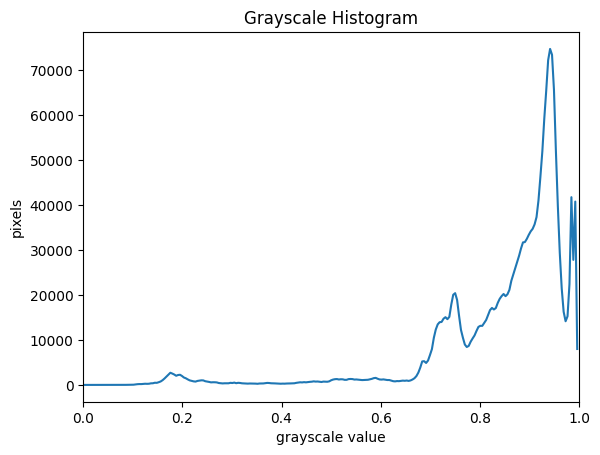

In [17]:
from PIL import Image
import cv2
import numpy as np
import glob
import skimage.io
import skimage.color
import skimage.filters
import matplotlib.pyplot as plt 

img = Image.open('/media/an/UBUNTU 20_0/HatDauXanh/img/hat (6).bmp')
img = np.array(img)
img = cv2.resize(cv2.cvtColor(img, cv2.COLOR_RGB2BGR), (1920,1080), interpolation= cv2.INTER_NEAREST)
cv2.imshow('img',img)
cv2.waitKey(0)

gray= skimage.color.rgb2gray(img)
# blur the image to denoise
blurred = skimage.filters.gaussian(gray, sigma=1.0)
cv2.imshow('gray', blurred)
cv2.waitKey(0)

histogram, bin_edges = np.histogram(blurred, bins=256, range=(0.0, 1.0))

fig, ax = plt.subplots()
plt.plot(bin_edges[0:-1], histogram)
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixels")
plt.xlim(0, 1.0)

t = 0.25
binary_mask = blurred < t 
binary_mask = binary_mask.astype(np.float32)
cv2.imshow('threshold', binary_mask)
cv2.waitKey(0)

size = 7
kernel = np.ones((size, size), np.uint8)
dilation = cv2.erode(binary_mask, kernel, iterations=1)
cv2.imshow('dilation', dilation)
cv2.waitKey(0)

cv2.destroyAllWindows()